In [1]:
import deepxde as dde 
import numpy as np 
import matplotlib.pyplot as plt
from defaults import DEFAULTS
from train import bc, ic, geomtime, burgers_equation, gen_testdata

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
influence_arrs = np.load("./model_zoo/influences/influence_arrs_finetune.npz")
influences = influence_arrs["influences"]
new_train_points = influence_arrs["new_train_points"]
OG_train_points = influence_arrs["train_x"]

In [3]:
influences.shape 

(2780, 13944)

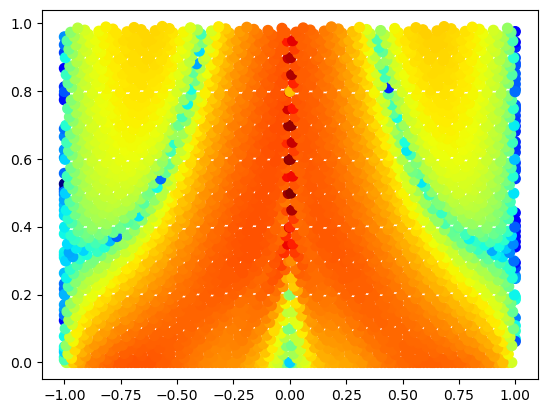

In [4]:
plt.scatter(*OG_train_points.T, c=np.log(np.abs(influences).sum(axis=1)), cmap="jet", s=50)

In [5]:
summed_abs_influences = np.abs(influences).sum(axis=0)

In [6]:
top_idx = np.argsort(summed_abs_influences)[::-1]

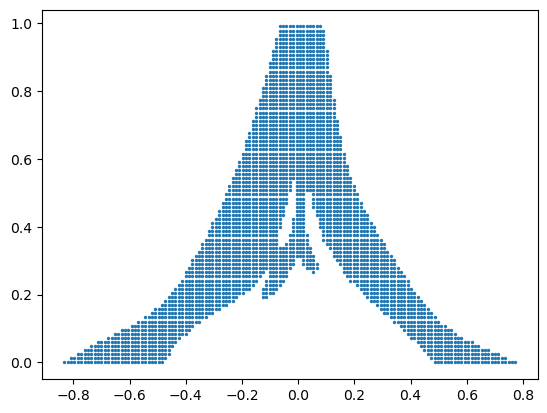

In [7]:
plt.scatter(*new_train_points[top_idx[:len(OG_train_points)]].T, s=2)

In [8]:
data = dde.data.TimePDE(
    geomtime,
    burgers_equation,
    ic_bcs=[bc, ic],
    num_domain=DEFAULTS['num_domain'],
    num_boundary=DEFAULTS['num_boundary'],
    num_initial=DEFAULTS['num_initial'],
)

test_x, test_y = gen_testdata()

net = dde.nn.FNN(DEFAULTS['layers'], "tanh", "Glorot normal")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
model.restore("./model_zoo/adam-50000.pt")

Compiling model...
'compile' took 0.371173 s



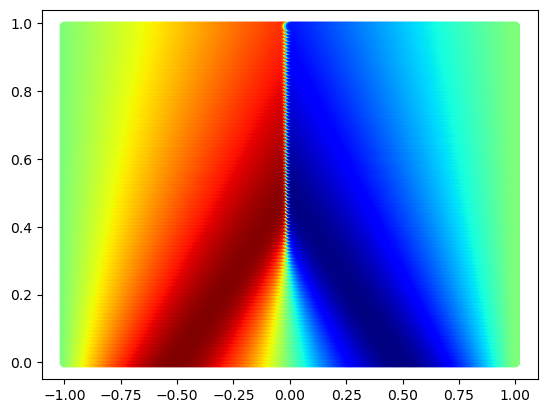

0.0015131564882438018

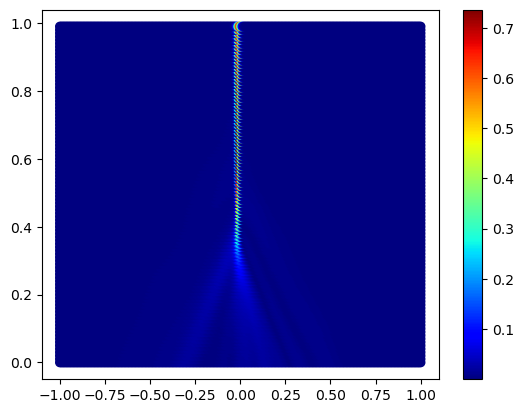

In [9]:
plt.scatter(*test_x.T, c=model.predict(test_x), cmap='jet')
plt.show()
plt.scatter(*test_x.T, c=np.abs(model.predict(test_x) - test_y), cmap='jet')
plt.colorbar()
(np.square(model.predict(test_x) - test_y)).mean()

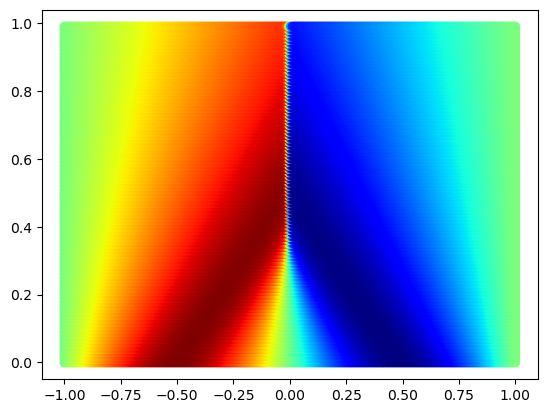

7.468255798780658e-05

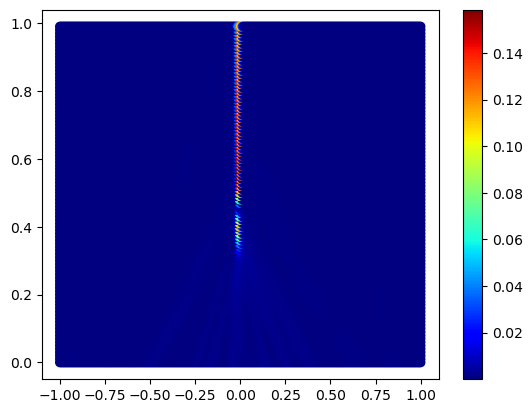

In [24]:
model_if = model 
model_if.restore("./model_zoo/finetuned_influence-10000.pt")
plt.scatter(*test_x.T, c=model.predict(test_x), cmap='jet')
plt.show()
plt.scatter(*test_x.T, c=np.abs(model.predict(test_x) - test_y), cmap='jet')
plt.colorbar()
(np.square(model.predict(test_x) - test_y)).mean()

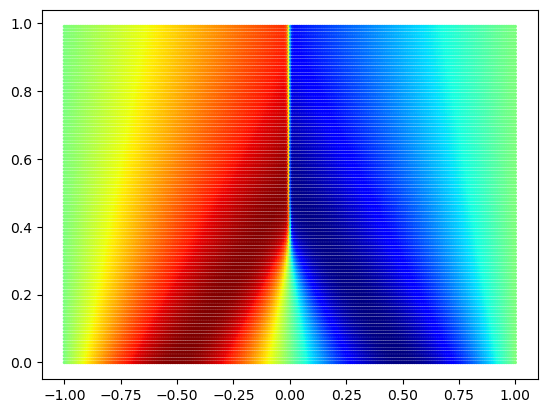

5.557933586836234e-05

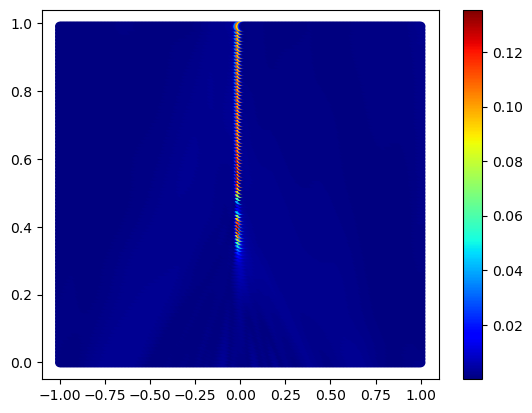

In [25]:
model_if = model 
model_if.restore("./model_zoo/finetuned_kacke-10000.pt")
plt.scatter(*test_x.T, c=model.predict(test_x), cmap='jet', s=2)
plt.show()
plt.scatter(*test_x.T, c=np.abs(model.predict(test_x) - test_y), cmap='jet')
plt.colorbar()
(np.square(model.predict(test_x) - test_y)).mean()

In [12]:
(np.square(model.predict(test_x) - test_y)).mean()

5.557933586836234e-05

In [13]:
data.train_x_all = new_train_points[:top_idx[len(OG_train_points)]]
data.train_x = None 
data.train_y = None 
data.train_aux_vars = None 
data.train_next_batch()
data.train_x_bc = None 
data.bc_points()

array([[-1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [-1.        ,  0.01207317],
       [ 1.        ,  0.01207317],
       [-1.        ,  0.02414634],
       [ 1.        ,  0.02414634],
       [-1.        ,  0.03621951],
       [ 1.        ,  0.03621951],
       [-1.        ,  0.04829268],
       [ 1.        ,  0.04829268],
       [-1.        ,  0.06036585],
       [ 1.        ,  0.06036585],
       [-1.        ,  0.07243902],
       [ 1.        ,  0.07243902],
       [-1.        ,  0.0845122 ],
       [ 1.        ,  0.0845122 ],
       [-1.        ,  0.09658536],
       [ 1.        ,  0.09658536],
       [-1.        ,  0.10865854],
       [ 1.        ,  0.10865854],
       [-1.        ,  0.1207317 ],
       [ 1.        ,  0.1207317 ],
       [-1.        ,  0.13280487],
       [ 1.        ,  0.13280487],
       [-1.        ,  0.14487804],
       [ 1.        ,  0.14487804],
       [-1.        ,  0.15695122],
       [ 1.        ,  0.15695122],
       [-1.        ,

In [14]:
data.bcs[0].on_boundary(new_train_points, data.geom.on_boundary(new_train_points)).sum()

166

In [15]:
data.bcs[0].on_boundary(new_train_points, data.geom.on_boundary(new_train_points))

array([ True, False, False, ..., False, False,  True])

In [16]:
data.bcs[1].on_initial(new_train_points, data.geom.on_initial(new_train_points)).sum()

168

In [17]:
data.bcs[1].on_initial(new_train_points, data.geom.on_initial(new_train_points))

array([ True,  True,  True, ..., False, False, False])

In [18]:
data.train_x_all.shape[0]

3292

In [19]:
data.train_x_all = new_train_points[top_idx[:len(OG_train_points)]]
data.train_x = None 
data.train_y = None 
data.train_aux_vars = None 
data.train_x_bc = None 
data.train_next_batch()

model = dde.Model(data, net)
model.compile("adam", lr=DEFAULTS["lr"])
model.train(iterations=10_000, display_every=1000)
model.save(f"{DEFAULTS['save_path']}/finetuned_influence")


Compiling model...
'compile' took 0.000187 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.63e-02, nan, 3.82e-06]         [4.70e-05, nan, 7.53e-01]         []  

Best model at step 0:
  train loss: inf
  test loss: inf
  test metric: 

'train' took 0.020768 s



'./model_zoo/finetuned_influence-1.pt'

In [20]:
data.train_x_all

array([[ 0.00598802,  0.39841464],
       [ 0.00598802,  0.38634145],
       [ 0.00598802,  0.4104878 ],
       ...,
       [-0.02994012,  0.50707316],
       [-0.1497006 ,  0.7485366 ],
       [-0.23353294,  0.18109757]], dtype=float32)

In [21]:
OG_train_points.shape

(2780, 2)

In [22]:
new_train_points.shape

(13944, 2)

In [23]:
new_train_points

array([[-1.        ,  0.        ],
       [-0.98802394,  0.        ],
       [-0.97604793,  0.        ],
       ...,
       [ 0.97604793,  0.99      ],
       [ 0.98802394,  0.99      ],
       [ 1.        ,  0.99      ]], dtype=float32)